In [ ]:
#from google.colab import drive
#drive.mount('/gdrive')

In [ ]:
#%cd /gdrive/My Drive/ANNDL-H1/

In [1]:

import numpy as np
import os
#DISABLE GPU
%env CUDA_VISIBLE_DEVICES= '' 
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' 

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) #DOSNT SHOW ALL TENSORFLOW WARNING; ONLY ERRORS
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    #tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    print(e)


import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import sys
#OUR CUSTOM HELPER CLASS
sys.path.append('../../../Utils/')
from DatasetHelper import DatasetHelper
from Utils import ModelHelper
import visualkeras

#ALLOW AUTORELOADING MODULES WHEN MODIFIED (Eg: our utility class)
%load_ext autoreload
%autoreload 2

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

env: CUDA_VISIBLE_DEVICES=''


2022-11-11 22:03:19.410097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-11 22:03:20.446458: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-11 22:03:22.042276: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:/usr/local/cuda-11.6/lib64::/home/nicomane/miniconda3/envs/tf/lib/
2022-11-11 22:03:22.042694: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic lib

2.10.0


In [2]:
print(tf.config.list_physical_devices('GPU'))

[]


In [3]:
# Dataset folders 
dataset_dir = '../../data'
training_dir = os.path.join(dataset_dir, '')

In [4]:
#Create Instances Of Utils Helper
seed = 42
labels = {0:'Species1', 1:'Species2', 2:'Species3', 3:'Species4',4:'Species5', 5:'Species6', 6:'Species7', 7:'Species8'}

#Dataset Helper
dataset_helper = DatasetHelper("../../",42) #Take in input dataset folder and random seed

#Model Helper
#SAVE MODEL IN LOCAL, IF MODEL IS GOOD; COPY IT BY HAND TO good_model Folder
model_helper   = ModelHelper("../../",labels) #take in input local models folder and lables
model_helper.create_seed(tf,seed);



In [8]:
#Load Dataset
X,Y = dataset_helper.load_dataset_from_numpy()
#X,Y = dataset_helper.load_Dataset(22)

dataset_size = X.shape[0]

Extracting data from dataset at: ../../data
Found 3542 images belonging to 8 classes.


100%|█████████████████████████████████████████████████████████████████████████████████| 442/442 [00:01<00:00, 420.67it/s]


In [10]:
X,Y = dataset_helper.load_dataset_from_numpy()

ValueError: Cannot load file containing pickled data when allow_pickle=False

In [6]:
#Split Training and Testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=int(0.1 * dataset_size),stratify = Y)

# Normalize data
X_train = X_train/255.
X_test = X_test/255.

#Split Training and Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, random_state=seed, test_size=int(0.1 * dataset_size),stratify = Y_train)

In [7]:
X_train.shape,X_test.shape,X_val.shape

((2830, 96, 96, 3), (353, 96, 96, 3), (353, 96, 96, 3))

In [8]:
Y_train.shape,Y_test.shape,Y_val.shape

((2830, 8), (353, 8), (353, 8))

In [9]:
input_shape = X_train.shape[1:] # 96*96*3
batch_size = 128
epochs = 100
input_shape

(96, 96, 3)

In [10]:
def build_model(input_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=32,
        kernel_size=(5, 5),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D(pool_size = (2, 2))(conv1)

    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(pool_size = (2, 2))(conv2)

    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(pool_size = (2, 2))(conv3)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool3)
    classifier_layer = tfkl.Dense(
        units=128, 
        name='Classifier', 
        activation='relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(flattening_layer)
    classifier_layer = tfkl.Dropout(0.5, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(
        units=8, 
        activation='softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name='Output'
    )(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856 

2022-11-11 17:56:48.139963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-11 17:56:48.140419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 17:56:48.140820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 17:56:48.141156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

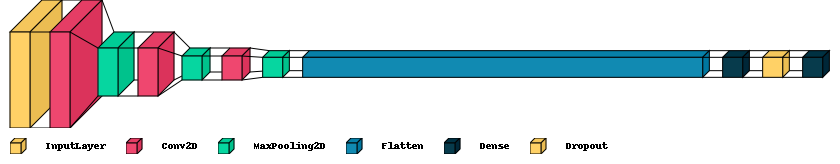

In [11]:
model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=1)

In [12]:
X_val.shape,Y_val.shape

((353, 96, 96, 3), (353, 8))

In [13]:
# Train the model
#%env TF_FORCE_UNIFIED_MEMORY: 1
 
history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, Y_val)
).history

2022-11-11 17:56:49.849729: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 312975360 exceeds 10% of free system memory.
2022-11-11 17:56:50.214326: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 312975360 exceeds 10% of free system memory.


Epoch 1/100


2022-11-11 17:56:52.167553: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-11-11 17:56:54.250409: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 536.01MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-11 17:56:54.295687: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 365.53MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-11 17:56:56.459798: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 340.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance


 1/23 [>.............................] - ETA: 3:09 - loss: 3.2862 - accuracy: 0.1328

2022-11-11 17:56:59.037253: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 728.75MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-11 17:56:59.037299: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 365.53MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


23/23 [==============================] - ETA: 0s - loss: 2.8818 - accuracy: 0.1618

2022-11-11 17:57:05.477439: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 410.07MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


23/23 [==============================] - 16s 344ms/step - loss: 2.8818 - accuracy: 0.1618 - val_loss: 2.0639 - val_accuracy: 0.1501
Epoch 2/100
 1/23 [>.............................] - ETA: 6s - loss: 2.0846 - accuracy: 0.1484

2022-11-11 17:57:06.807266: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 243.28MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-11 17:57:06.807634: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 243.28MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


23/23 [==============================] - 7s 284ms/step - loss: 2.0084 - accuracy: 0.1742 - val_loss: 1.9440 - val_accuracy: 0.2833
Epoch 3/100
13/23 [===============>..............] - ETA: 2s - loss: 1.9351 - accuracy: 0.2392

KeyboardInterrupt: 

In [ ]:
model_helper.save_model(model,'model1')

In [ ]:

model = model_helper.load_model('model1')
model.summary()

In [ ]:
model_helper.show_prediction(X_test,Y_test,66)

In [ ]:
#PLOT THE TRAINING PHASE VS VALIDATION BOTH IN LOSS AND ACCURACY
model_helper.plot_phase_train_vs_validation(history)

In [ ]:
#PLOT CONFUSION MATRIX OF OUR MODEL
#It is good if diagonal has high values and other part of matrix is dark
#Bad if a row has ALL dark cells
#EG species 1 and species 6 has less images in the datase... and here the confusion matrix has all black on them..
model_helper.show_confusion_matrix(X_test,Y_test)

In [ ]:
#Submission Model for the challenge -> Path is the folder on the server where our script is
class SubmissionModel:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'model1'))

    def predict(self, X):
        
        # Insert your preprocessing here

        out = self.model.predict(X)
        out = np.argmax(out, axis=-1)
        return out

In [ ]:
testing_index = 44
image_to_test = X_test[[testing_index],:]
#image_to_test = X_test[10,None,:]
#image_to_test = np.expand_dims(image_to_test,0)
image_to_test.shape


In [ ]:
print("Real Class: ")
print(labels[np.argmax(Y_test[testing_index])])
tester = SubmissionModel("../../local_saved_models/")
res = tester.predict(image_to_test)
labels[res[0]]

In [ ]:
#Predict all test at oance
predicted_vector = model.predict(X_test)
predicted_vector.shape